In [209]:
import sys

In [609]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [167]:
src_conn = sqlite3.connect('/Volumes/Samsung_T5/databases/Hela_20A_20R_500-features.sqlite')
src_c = src_conn.cursor()

src_conn_2 = sqlite3.connect('/Volumes/Samsung_T5/databases/Hela_20A_20R_500-features-1-100000-random-1000-sf-1000.sqlite')
src_c_2 = src_conn_2.cursor()

In [174]:
feature_ids_df = pd.read_sql_query("select distinct(feature_id) from peak_correlation", src_conn_2)

In [612]:
# pick 20 feature IDs from the collection
random_feature_indexes = random.sample(range(len(feature_ids_df)), 20)
feature_ids_df = feature_ids_df.iloc[random_feature_indexes]
feature_ids_df.sort_values(by='feature_id', inplace=True)
feature_ids_df

,feature_id
19,2259
98,11042
172,17495
175,17528
331,35209
338,35678
350,36356
395,40608
438,44764
452,46565


In [998]:
FEATURE_ID = 35209

In [999]:
feature_df = pd.read_sql_query("select * from features where feature_id = {}".format(FEATURE_ID), src_conn)
charge_state = feature_df.loc[0].charge_state.astype(int)

In [1000]:
peaks_df = pd.read_sql_query("select * from summed_ms1_regions where feature_id = {} order by peak_id".format(FEATURE_ID), src_conn_2)

In [1001]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

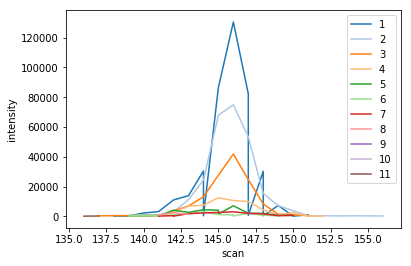

In [1002]:
fig, ax = plt.subplots()
groups = peaks_df.groupby('peak_id')
for i, (name, group) in enumerate(groups):
    ax.plot(group.scan, group.intensity, color=tableau20[i], label=name)
plt.legend(loc='best')
plt.xlabel('scan')
plt.ylabel('intensity')
plt.margins(0.06)
plt.show()

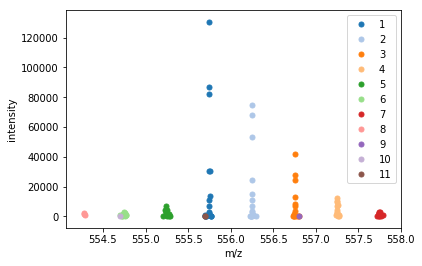

In [1003]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
groups = peaks_df.groupby('peak_id')
for i, (name, group) in enumerate(groups):
    ax.plot(group.mz, group.intensity, marker='o', color=tableau20[i], linestyle='', ms=5, label=name)
plt.legend(loc='best')
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
plt.show()

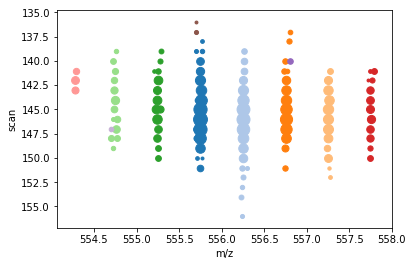

In [1004]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
groups = peaks_df.groupby('peak_id')
for i, (name, group) in enumerate(groups):
    for data_point in group.itertuples():
        markersize = 10+1.5*np.log(data_point.intensity*0.0001)
        ax.plot(data_point.mz, data_point.scan, marker='o', color=tableau20[i], linestyle='', markersize=markersize, label=name)
# plt.legend(loc='best')
plt.xlabel('m/z')
plt.ylabel('scan')
plt.gca().invert_yaxis()
plt.margins(0.06)
plt.show()

In [1005]:
def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [1006]:
mzs = peaks_df.groupby('peak_id').apply(wavg, "mz", "intensity").reset_index(name='mz_centroid')

In [1007]:
mzs

,peak_id,mz_centroid
0,1,555.751010
1,2,556.252785
2,3,556.754351
3,4,557.252625
4,5,555.245978
5,6,554.745607
6,7,557.746059
7,8,554.279464
8,9,556.797021
9,10,554.705992


In [1008]:
intensities = peaks_df.groupby('peak_id').intensity.sum().reset_index(name='summed_intensity')

In [1009]:
intensities

,peak_id,summed_intensity
0,1,400793
1,2,265172
2,3,129801
3,4,58456
4,5,30245
5,6,12982
6,7,15509
7,8,4606
8,9,522
9,10,274


In [1010]:
cluster_df = pd.concat([mzs, intensities.summed_intensity], axis=1)

In [1011]:
cluster_df

,peak_id,mz_centroid,summed_intensity
0,1,555.751010,400793
1,2,556.252785,265172
2,3,556.754351,129801
3,4,557.252625,58456
4,5,555.245978,30245
5,6,554.745607,12982
6,7,557.746059,15509
7,8,554.279464,4606
8,9,556.797021,522
9,10,554.705992,274


In [1012]:
cluster_df.sort_values(by='mz_centroid', inplace=True)

In [1013]:
cluster_df

,peak_id,mz_centroid,summed_intensity
7,8,554.279464,4606
9,10,554.705992,274
5,6,554.745607,12982
4,5,555.245978,30245
10,11,555.702281,284
0,1,555.751010,400793
1,2,556.252785,265172
2,3,556.754351,129801
8,9,556.797021,522
3,4,557.252625,58456


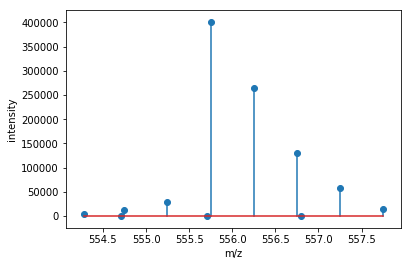

In [1014]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(cluster_df.mz_centroid, cluster_df.summed_intensity)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
plt.show()

In [1015]:
cluster_df.reset_index(drop=True, inplace=True)
base_peak_index = cluster_df.summed_intensity.idxmax()
cluster_df

,peak_id,mz_centroid,summed_intensity
0,8,554.279464,4606
1,10,554.705992,274
2,6,554.745607,12982
3,5,555.245978,30245
4,11,555.702281,284
5,1,555.751010,400793
6,2,556.252785,265172
7,3,556.754351,129801
8,9,556.797021,522
9,4,557.252625,58456


In [1016]:
expected_spacing = DELTA_MZ / charge_state
base_peak_mz = cluster_df.iloc[base_peak_index].mz_centroid
spacing_from_base = abs((cluster_df.mz_centroid - base_peak_mz) - (cluster_df.index - base_peak_index)*expected_spacing)
spacing_from_base

0     1.036842
1     0.961692
2     0.499630
3     0.498323
4     0.452948
5     0.000000
6     0.000097
7     0.000014
8     0.459022
9     0.505095
10    0.513339
Name: mz_centroid, dtype: float64

In [1017]:
indexes_to_drop = spacing_from_base > 0.1
indexes_to_drop

0      True
1      True
2      True
3      True
4      True
5     False
6     False
7     False
8      True
9      True
10     True
Name: mz_centroid, dtype: bool

In [1018]:
cluster_df.drop(cluster_df.index[indexes_to_drop], inplace=True)
cluster_df.reset_index(drop=True, inplace=True)
base_peak_index = cluster_df.summed_intensity.idxmax()
base_peak_mz = cluster_df.iloc[base_peak_index].mz_centroid

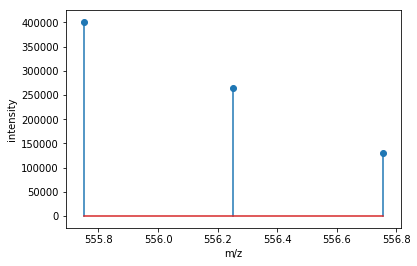

In [1019]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(cluster_df.mz_centroid, cluster_df.summed_intensity)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
plt.show()

In [1020]:
MAX_NUMBER_OF_SULPHUR_ATOMS = 3
MAX_NUMBER_OF_PREDICTED_RATIOS = 6

S0_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=object)
S0_r[1] = [-0.00142320578040, 0.53158267080224, 0.00572776591574, -0.00040226083326, -0.00007968737684]
S0_r[2] = [0.06258138406507, 0.24252967352808, 0.01729736525102, -0.00427641490976, 0.00038011211412]
S0_r[3] = [0.03092092306220, 0.22353930450345, -0.02630395501009, 0.00728183023772, -0.00073155573939]
S0_r[4] = [-0.02490747037406, 0.26363266501679, -0.07330346656184, 0.01876886839392, -0.00176688757979]
S0_r[5] = [-0.19423148776489, 0.45952477474223, -0.18163820209523, 0.04173579115885, -0.00355426505742]
S0_r[6] = [0.04574408690798, -0.05092121193598, 0.13874539944789, -0.04344815868749, 0.00449747222180]

S1_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=object)
S1_r[1] = [-0.01040584267474, 0.53121149663696, 0.00576913817747, -0.00039325152252, -0.00007954180489]
S1_r[2] = [0.37339166598255, -0.15814640001919, 0.24085046064819, -0.06068695741919, 0.00563606634601]
S1_r[3] = [0.06969331604484, 0.28154425636993, -0.08121643989151, 0.02372741957255, -0.00238998426027]
S1_r[4] = [0.04462649178239, 0.23204790123388, -0.06083969521863, 0.01564282892512, -0.00145145206815]
S1_r[5] = [-0.20727547407753, 0.53536509500863, -0.22521649838170, 0.05180965157326, -0.00439750995163]
S1_r[6] = [0.27169670700251, -0.37192045082925, 0.31939855191976, -0.08668833166842, 0.00822975581940]

S2_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=object)
S2_r[1] = [-0.01937823810470, 0.53084210514216, 0.00580573751882, -0.00038281138203, -0.00007958217070]
S2_r[2] = [0.68496829280011, -0.54558176102022, 0.44926662609767, -0.11154849560657, 0.01023294598884]
S2_r[3] = [0.04215807391059, 0.40434195078925, -0.15884974959493, 0.04319968814535, -0.00413693825139]
S2_r[4] = [0.14015578207913, 0.14407679007180, -0.01310480312503, 0.00362292256563, -0.00034189078786]
S2_r[5] = [-0.02549241716294, 0.32153542852101, -0.11409513283836, 0.02617210469576, -0.00221816103608]
S2_r[6] = [-0.14490868030324, 0.33629928307361, -0.08223564735018, 0.01023410734015, -0.00027717589598]

model_params = np.empty(MAX_NUMBER_OF_SULPHUR_ATOMS, dtype=object)
model_params[0] = S0_r
model_params[1] = S1_r
model_params[2] = S2_r

# Find the ratio of H(peak_number)/H(peak_number-1) for peak_number=1..6
# peak_number = 0 refers to the monoisotopic peak
# number_of_sulphur = number of sulphur atoms in the molecule
def peak_ratio(monoisotopic_mass, peak_number, number_of_sulphur):
    ratio = 0.0
    if (((1 <= peak_number <= 3) & (((number_of_sulphur == 0) & (498 <= monoisotopic_mass <= 3915)) |
                                    ((number_of_sulphur == 1) & (530 <= monoisotopic_mass <= 3947)) |
                                    ((number_of_sulphur == 2) & (562 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 4) & (((number_of_sulphur == 0) & (907 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (939 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (971 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 5) & (((number_of_sulphur == 0) & (1219 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1251 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1283 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 6) & (((number_of_sulphur == 0) & (1559 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1591 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1623 <= monoisotopic_mass <= 3978))))):
        beta0 = model_params[number_of_sulphur][peak_number][0]
        beta1 = model_params[number_of_sulphur][peak_number][1]
        beta2 = model_params[number_of_sulphur][peak_number][2]
        beta3 = model_params[number_of_sulphur][peak_number][3]
        beta4 = model_params[number_of_sulphur][peak_number][4]
        scaled_m = monoisotopic_mass / 1000.0
        ratio = beta0 + (beta1*scaled_m) + beta2*(scaled_m**2) + beta3*(scaled_m**3) + beta4*(scaled_m**4)
    return ratio


In [1021]:
DELTA_MZ = 1.003355     # mass difference between Carbon-12 and Carbon-13 isotopes, in Da
PROTON_MASS = 1.007276  # mass of a proton in unified atomic mass units, or Da

In [1022]:
# find the combination of mono index and sulphurs that gives the smallest total height ratio error
minimum_error = sys.float_info.max
minimum_error_sulphur = None
minimum_error_mono_index = None

for test_mono_index in range(0,base_peak_index+1):  # consider moving it up to the base peak (but not beyond)
    test_monoisotopic_mass = (cluster_df.loc[test_mono_index].mz_centroid - PROTON_MASS) * charge_state
    for sulphur in range(0,MAX_NUMBER_OF_SULPHUR_ATOMS):
        error = 0
        number_of_peaks_to_test = min(MAX_NUMBER_OF_PREDICTED_RATIOS, len(cluster_df)-test_mono_index)
        for peak_number in range(1,number_of_peaks_to_test):
            predicted_ratio = peak_ratio(test_monoisotopic_mass, peak_number=peak_number, number_of_sulphur=sulphur)
            if predicted_ratio > 0:
                observed_ratio = cluster_df.loc[test_mono_index+peak_number].summed_intensity / cluster_df.loc[test_mono_index+peak_number-1].summed_intensity
                error += (predicted_ratio - observed_ratio)**2 / predicted_ratio
        if error < minimum_error:
            minimum_error = error
            minimum_error_sulphur = sulphur
            minimum_error_mono_index = test_mono_index
monoisotopic_mass = (cluster_df.loc[minimum_error_mono_index].mz_centroid - PROTON_MASS) * feature_df.loc[0].charge_state
print("mono index: {}, sulphurs {}, monoisotopic mass {}, minimum error {}".format(minimum_error_mono_index, minimum_error_sulphur, monoisotopic_mass, minimum_error))

mono index: 0, sulphurs 2, monoisotopic mass 1109.4874680263495, minimum error 0.01277977237565053


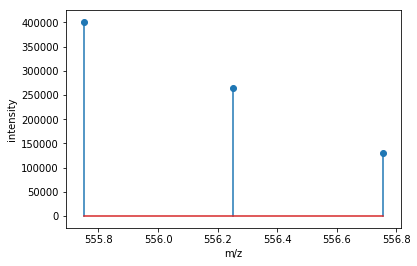

In [1023]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(cluster_df.mz_centroid, cluster_df.summed_intensity)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
plt.show()